In [ ]:
#default_exp bbox_east_inference

In [ ]:
#export
from fastai import *
from fastai.vision import *
import numpy as np
import cv2

from facelib.face_east_training import *
from facelib.face_east_training import east_config
from facelib.face_east_training import create_grid
from facelib.core import load_inference, plot

In [ ]:
east_config.input_shape

(512, 384)

In [ ]:
#export
resize_one_img = lambda x, size: F.interpolate(x[None], size=size, mode='bilinear', align_corners=True)[0]

class TextBBoxPredictor:
    def __init__(self, model_name, use_gpu=False, trained_input_shape=east_config.input_shape, out_shape=east_config.out_shape):
        '''
        @param: str       :name of model in ../models dir
        @param: bool      :use gpu? (model ~800mb)
        @param: np.arr[2] :[height, width] of image (when training)
        @param: np.arr[2] :[h_in/h_out, w_in/w_out] (how much output is smaller then input)
        '''
        self.model_name, self.use_gpu = model_name, use_gpu
        if self.use_gpu: defaults.device = torch.device('cuda')
        else: defaults.device = torch.device('cpu')
        self.learner = load_inference(model_name)
        self.train_shape = tensor(trained_input_shape)
        self.out_shape = tensor(out_shape)
        self.anchors = create_grid(tuple(self.train_shape//self.out_shape)).view(-1,4)
        
    def image2bboxes(self, image, shape='train', offset=0, detect_thresh=0.8, nms_threshold=0.2):
        ''' 
        @param: torch.arr [h,w,3] :(make sure its in RGB not BGR! and pixel range is [0-255])
        @param: np.arr [2]        :[height, width] of nn input (if None leaves the same, if 'train' leaves self.train_shape)
        @param: int               :make each box bigger by `offset` amount
        @param: float             :bboxes are considered found only if p(bbox) > this
        @param: float             :if IoU(bbox1,bbox2)>this, then it is same bbox
        @return torch.arr[N,4]    :list of [top,left,btm,right] coords
        '''
        # preprocess image
        if image.size(2) == 3: image = image.permute(2,0,1) # [3,h,w]
        im_orig = image
        c, h_orig, w_orig = image.shape
        if shape is not None:
            shape = tensor(shape) if shape != 'train' else self.train_shape
            if len(image.shape) == 3: image = image[None]
            image = F.interpolate(image.type(torch.float32), size=tuple(shape), mode='bilinear', align_corners=True).squeeze() # [3,h,w]
        # get ready for learner
        image = Image(image.float() / 255.)
        batch = self.learner.data.one_item(image)
        # predict w/ model
        score, geo, other_lbls, mask = self.learner.model.eval()(batch[0]) # [1,1,H,W], [1,4,H,W], list, [1,1,H,W]
        bbox_pred = geo[0].permute(1,2,0).view(-1,4)
        y_pred = score[0].view(-1,1)
        # preprocess bboxes
        anchors = self.anchors
        if shape is None: shape = (h_orig, w_orig)
        if (shape != self.train_shape).all(): anchors = create_grid(tuple(tensor(shape)//self.out_shape)).view(-1,4)
        bbox_pred = target_to_bbox(bbox_pred, self.anchors.to(y_pred.device))
        # filter w/ small probs
        detect_mask = y_pred.squeeze() > detect_thresh # [H x W]
        if detect_mask.sum() == 0: pass
        # non maximum suppression
        t = bbox_pred[detect_mask]
        keep_idxes = nms(t, y_pred[detect_mask].view(-1), threshold=nms_threshold)
        bboxes = to_np(t[keep_idxes]) # [N,4]
        # resize bboxes
        resized_bboxes = []
        for t,l,b,r in bboxes:
            # denormalize
            t,b = tuple(map(lambda x: int((x+1)/2*h_orig), [t,b]))
            l,r = tuple(map(lambda x: int((x+1)/2*w_orig), [l,r]))
            # offset
            t -= offset
            l -= offset
            b += offset
            r += offset
            # fit into image
            t,l = tuple(map(lambda x: max(x, 0), [t,l]))
            b = min(b, h_orig)
            r = min(r, w_orig)
            resized_bboxes.append([t,l,b,r])
        return tensor(resized_bboxes).long(), resize_one_img(mask, (h_orig, w_orig)).squeeze(), other_lbls

In [ ]:
# old
def show_bboxes_on_image(im, bboxes):
    # [h,w,3]
    # [N,4]
    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    imageBB = ImageBBox.create(*im.shape[:2], tensor(bboxes), scale=True)
    return Image(tensor(im).permute(2,0,1).float() / 255.).show(ax=ax, y=imageBB)

In [ ]:
#export
def bboxes_on_image(im, bboxes): # [h,w,3], [N,4]
    im = im.copy()
    for bb in bboxes: # [4]
        im = cv2.rectangle(im, (bb[1],bb[0]), (bb[3],bb[2]), (255,255,0), thickness=10) 
    return im

def show_bboxes_on_image(im, bboxes, **kwargs):
    return plot(bboxes_on_image(im, bboxes), **kwargs)

In [ ]:
im = cv2.imread('../test_data/Face629.jpg')
im = im[:,:,[2,1,0]]

In [ ]:
t = TextBBoxPredictor(model_name='east_bbox_5x3_resnet18', use_gpu=False)
bboxes, mask, other_lbls = t.image2bboxes(tensor(im))

In [ ]:
MODEL = t.learner.model.to('cpu')

In [ ]:
a = np.arange(10)
a = list(map(str, list(a)))
[a[i]+a[i+1] for i in range(0,len(a),2)]

['01', '23', '45', '67', '89']

In [ ]:
INPUT = (512,384)

def create_grid(size):
    ''' Creates a x,y grid of size `size`, coords start from -1 to 1
    @param: tuple(H,W) :tuple of 2 ints H(height), W(width)
    @return [H,W,4]    :tlbr coords for each (h,w) cell 
    '''
    H, W = size if is_tuple(size) else (size,size)
    grid = torch.FloatTensor(H, W, 4)
    
    # not precise, but good enough
    linear_points_left = torch.linspace(0, 1-1/W, W) # [0, 1]
    linear_points_right = linear_points_left + 1/W
    linear_points_top = torch.linspace(0, 1-1/H, H) # [0, 1]
    linear_points_btm = linear_points_top + 1/H
    
    grid[:, :, 0] = linear_points_top.unsqueeze(1).expand(H,W)
    grid[:, :, 1] = linear_points_left.unsqueeze(0).expand(H,W)
    grid[:, :, 2] = linear_points_btm.unsqueeze(1).expand(H,W)
    grid[:, :, 3] = linear_points_right.unsqueeze(0).expand(H,W)
    return grid*2-1

def target_to_bbox(output, anchors):
    a_centers = tlbr2cc(anchors)
    return torch.cat([a_centers - output[...,:2], a_centers + output[...,2:]], -1)

def prepare_output(o): # [1,n,h,w], n - can be different for each output
    ''' [1,n,h,w] -> [h*w,n] '''
    o = o[0].permute(1,2,0)
    return o.view(-1,o.shape[-1])

ANCHORS = create_grid((INPUT[0]//4, INPUT[1]//4)).view(-1,4)

def image2preds(img, config):
    out = []
    h_orig, w_orig, c = img.shape
    img = cv2.resize(img, dsize=(INPUT[1], INPUT[0]))
    im = tensor(img).permute(2,0,1).float() / 255.
    score, geo, other_lbls, mask = MODEL(im[None])
    bins, floats = other_lbls
    score, geo, bins, floats = map(prepare_output, [score, geo, bins, floats]) # [h*w,n], where n - can be different
    geo = target_to_bbox(geo, ANCHORS.to(geo.device))
    mask = np.ascontiguousarray(mask.squeeze().detach().numpy()) # [h,w]
    mask = (mask*255).astype(np.uint8)
    mask = cv2.resize(mask[:,:,None], dsize=(w_orig,h_orig)).squeeze()
    # get a single face
    face_idx = score.squeeze().argmax(dim=-1)
    score = float(score.squeeze()[face_idx])
    (t,l,b,r), bins, floats = map(lambda x: x[face_idx], [geo, bins, floats])
    t,b = tuple(map(lambda x: int((x+1)/2*h_orig), [t,b]))
    l,r = tuple(map(lambda x: int((x+1)/2*w_orig), [l,r]))
    geo = {k:int(v) for k,v in zip(['t','l','b','r'], (t,l,b,r))}
    bins = {k:float(v) for k,v in zip(binary_predictions, bins)}
    floats = {k:float(v) for k,v in zip(float_predictions, floats)}

    return score, geo, bins, floats, mask

In [ ]:
score, geo, bins, floats, mask = image2preds(im, None)

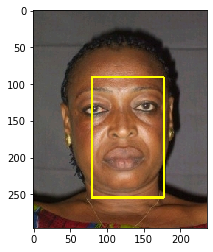

In [ ]:
img = im.copy()
t,l,b,r = map(lambda n: geo[n], ['t','l','b','r'])
img = cv2.rectangle(img, (l,t), (r,b), color=(255,255,0), thickness=2)
plot(img)

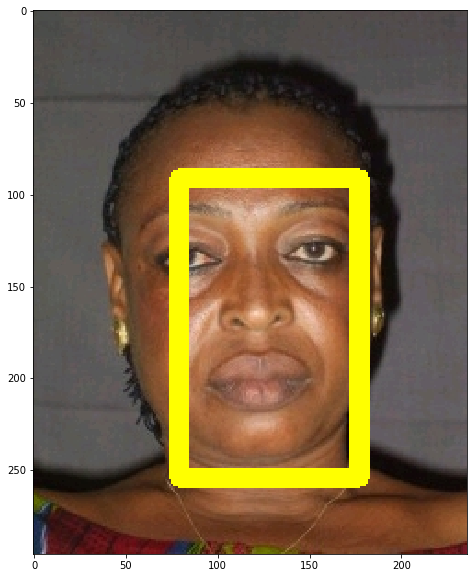

In [ ]:
show_bboxes_on_image(im, bboxes, figsize=(10,10))

### ONNX

In [ ]:
# step 1, load pytorch model and export onnx during running.
model_name = 'east_bbox_5x3_resnet18'
t = TextBBoxPredictor(model_name=model_name, use_gpu=False)
model = t.learner.model

In [ ]:
dummy_input = torch.randn(1,3,east_config.HEIGHT,east_config.WIDTH)
torch.onnx.export(model, dummy_input, '../models/onnx/'+model_name, verbose=True, opset_version=9)
# opset_version=11 - https://github.com/pytorch/pytorch/issues/29980

/home/dominykas/anaconda3/envs/nlp/lib/python3.7/site-packages/torch/onnx/symbolic_helper.py:198: UserWarning: You are trying to export the model with onnx:Upsample for ONNX opset version 9. This operator might cause results to not match the expected results by PyTorch.
ONNX's Upsample/Resize operator did not match Pytorch's Interpolation until opset 11. Attributes to determine how to transform the input were added in onnx:Resize in opset 11 to support Pytorch's behavior (like coordinate_transformation_mode and nearest_mode).
We recommend using opset 11 and above for models using this operator. 
  "" + str(_export_onnx_opset_version) + ". "
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=10000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Times

In [ ]:
model = EastModel()

In [ ]:
%%timeit
model(torch.randn(1,3,512,384))

85.5 ms ± 975 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
model(torch.randn(1,3,224,224))

28.8 ms ± 19.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
model(torch.randn(4,3,224,224))

62.2 ms ± 74.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
from facelib.face_east_training import *
predictor_gpu = TextBBoxPredictor(model_name='east_bbox_5x3_resnet18', use_gpu=True)
predictor_cpu = TextBBoxPredictor(model_name='east_bbox_5x3_resnet18', use_gpu=False)

In [ ]:
%%timeit
_ = predictor_cpu.image2bboxes(tensor(im), shape=(512,368))

92.3 ms ± 533 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
_ = predictor_cpu.image2bboxes(tensor(im), shape=(224,224))

90.9 ms ± 823 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
_ = predictor_gpu.image2bboxes(tensor(im), shape='train')

60.8 ms ± 936 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
_ = predictor_gpu.image2bboxes(tensor(im), shape=(1024,1024))

73.7 ms ± 211 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
